In [19]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [20]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
    

training_dir = "HackathonIII/Expression_data/Facial_expression_train/"
testing_dir = "HackathonIII/Expression_data/Facial_expression_test/"
train_batch_size = 100
test_batch_size = 10
train_number_epochs = 100

In [35]:
train_data = torchvision.datasets.ImageFolder(training_dir, transform=transforms.Compose([transforms.Resize((48,48)),
                                                                                         transforms.Grayscale(num_output_channels=1),
                                                                      transforms.ToTensor()
                                                                      ]))
classes = train_data.classes



In [40]:
test_data = torchvision.datasets.ImageFolder(testing_dir, transform=transforms.Compose([transforms.Resize((48,48)),
                                                                                         transforms.Grayscale(num_output_channels=1),
                                                                      transforms.ToTensor()
                                                                      ]))

In [41]:
from torchvision import transforms


train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=1)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=test_batch_size,
                                          shuffle=False,
                                          num_workers=1)

Mini batch size: images - torch.Size([100, 1, 48, 48])  labels -  torch.Size([100])
torch.Size([1, 48, 48]) tensor(1)


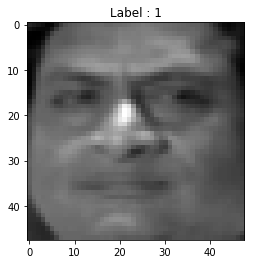

torch.Size([1, 48, 48]) tensor(4)


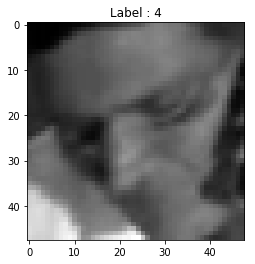

Mini batch size: images - torch.Size([100, 1, 48, 48])  labels -  torch.Size([100])
torch.Size([1, 48, 48]) tensor(0)


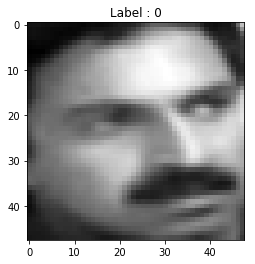

torch.Size([1, 48, 48]) tensor(0)


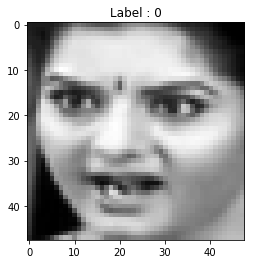

In [42]:
count = 0
for mini_batch in train_loader:
    images, labels = mini_batch
    print('Mini batch size: images -', images.size(), ' labels - ', labels.size())
    for j in range(train_batch_size):
        print(images[j].size(), labels[j])
        plt.imshow(images[j][0].numpy(), cmap='gray')
        plt.title('Label : %i' % labels[j])
        plt.show()

# Some logic to break the loops so that we dont print the whole dataset.
        if j == 1:
            break
    if count == 1:
        break
        
    count +=1

In [27]:
# A CNN based Feature extractor
# Definining neural network in python by a class which inherits from nn.Module
class LeNet(nn.Module):
    """LeNet feature extractor model."""

    def __init__(self):
        """Init LeNet feature extractor model."""
        super(LeNet, self).__init__()

        # Defining the CNNfeature Extractor
        self.feature_extractor = nn.Sequential(
            # input [1 x 128 x 128]
            #[1 x 48 x 48]
            # 1st conv layer
            # Conv which convolves input image with 6 filters of 5x5 size, without padding
            nn.Conv2d(1, 6, kernel_size=5),
            # [6 x 124 x 124]
            # [6 x 44 x 44]
            nn.MaxPool2d(kernel_size=2), # Max pooling subsampling operation
            # [6 x 62 x 62]
            # [6 x 22 x 22]
            nn.ReLU(), # Non linear activation function
            # 2nd conv layer
            # input [6 x 62 x 62], [6 x 22 x 22]
            # Conv which convolves input image with 16 filters of 5x5 size, without padding
            nn.Conv2d(6, 16, kernel_size=5),
            # [16 x 58 x 58]
            # [16 x 18 x 18]
            nn.MaxPool2d(kernel_size=2),
            # [16 x 29 x 29]
            #[16 x 9 x 9]
            nn.ReLU()
        )
        
        # Defining the Classifier
        self.classifier = nn.Sequential(
            # Linear layer with 120 nodes, taking a flattened [16 x 4 x 4] as input
            #nn.Linear(16 * 29 * 29, 120),
            nn.Linear(16 * 9 * 9, 120),
            # Linear layer with 84 nodes
            nn.Linear(120, 84),
            # ReLU
            nn.ReLU(),
            # Output layer with as many nodes as number of classes
            nn.Linear(84, 7)
        )
        
    def forward(self, input):
        """Define a Forward pass of the LeNet."""
        out = self.feature_extractor(input) # Pass input through the feature extractor
        #out = out.view(-1, 16 * 29 * 29) # Reshape the 2D to a vector
        out = out.view(-1, 16 * 9 * 9) # Reshape the 2D to a vector
        out = self.classifier(out) # pass features through the classifier to get predictions
        return out

In [28]:
lenet = LeNet()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lenet = lenet.to(device)

# Print out the size of parameters of each layer
for name, param in lenet.state_dict().items():
    print(name, '\n', param.size(), '\n')

feature_extractor.0.weight 
 torch.Size([6, 1, 5, 5]) 

feature_extractor.0.bias 
 torch.Size([6]) 

feature_extractor.3.weight 
 torch.Size([16, 6, 5, 5]) 

feature_extractor.3.bias 
 torch.Size([16]) 

classifier.0.weight 
 torch.Size([120, 1296]) 

classifier.0.bias 
 torch.Size([120]) 

classifier.1.weight 
 torch.Size([84, 120]) 

classifier.1.bias 
 torch.Size([84]) 

classifier.3.weight 
 torch.Size([7, 84]) 

classifier.3.bias 
 torch.Size([7]) 



In [29]:
train_loader.batch_size

100

In [31]:
epoch = 40
loss_history = []
lenet = LeNet()
# The number of times we should iterate over the training data. 1 epoch = 1 pass over the training data

loss_func = nn.CrossEntropyLoss()

# Set the learning rate
learning_rate = 0.001

optimizer = torch.optim.Adam(lenet.parameters(), lr=learning_rate)


####### Epoch  0
loss so far:  0.5632292032241821
loss so far:  0.5588559508323669
batch completed 109
####### Epoch  1
loss so far:  0.4255548417568207
loss so far:  0.42600494623184204
batch completed 109
####### Epoch  2
loss so far:  0.5394250750541687
loss so far:  0.5189799666404724
batch completed 109
####### Epoch  3
loss so far:  0.38795334100723267
loss so far:  0.589179277420044
batch completed 109
####### Epoch  4
loss so far:  0.4301701784133911
loss so far:  0.4713752865791321
batch completed 109
####### Epoch  5
loss so far:  0.3287096917629242
loss so far:  0.30681565403938293
batch completed 109
####### Epoch  6
loss so far:  0.2712841331958771
loss so far:  0.43994495272636414
batch completed 109
####### Epoch  7
loss so far:  0.32753437757492065
loss so far:  0.32429972290992737
batch completed 109
####### Epoch  8
loss so far:  0.2383240908384323
loss so far:  0.39489805698394775
batch completed 109
####### Epoch  9
loss so far:  0.27723637223243713
loss so far:  0.

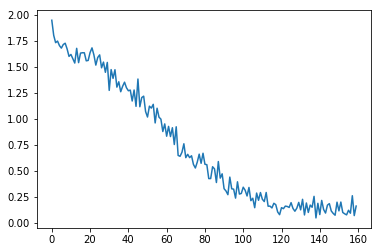

In [47]:
# optimizer = torch.optim.SGD(lenet.parameters(), lr=learning_rate, momentum=0.0)
# Train Model with train data

for i in range(epoch):
    print('####### Epoch ', i)
    for j,[image,label] in enumerate(train_loader):
        # You can try with and without using GPUs, by setting this variable before the loop
        #if use_gpu == "cuda":
        image = image.to(device)
        label = label.to(device)
            
        #image = image
        #label = label
        
        
        optimizer.zero_grad() # zero out the gradients from the preivous step 
        predictions = lenet.forward(image) # Do forward pass on the current mini batch
        
        loss = loss_func(predictions, label) # Compute loss on the current mini batch
        loss.backward() # Do backward pass. That is compute all the gradients for the current minibatch
        optimizer.step() # Update the parameters using the gradients with the learning rate
        
        if j % 100 == 0:
            print("loss so far: ", loss.item())
            loss_history.append(loss.item())
                    
        # display.clear_output(wait=True)
    print("batch completed", j)
plt.plot(loss_history)
plt.show()

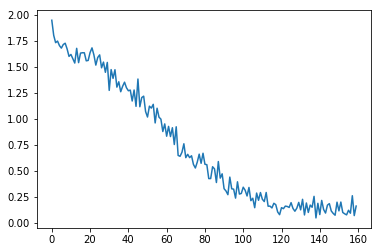

LeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=1296, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): ReLU()
    (3): Linear(in_features=84, out_features=7, bias=True)
  )
)


In [48]:
plt.plot(loss_history)
plt.show()
print(lenet)

In [52]:
correct = 0.0
total = 0.0
for mini_batch in test_loader:
    images, labels = mini_batch
    
    # You can try with and without using GPUs, by setting this variable before the loop
    #if use_gpu == "cuda":
    #images = images.to(device)
    #labels = labels.to(device)
        
    #images = images
    
    # Doing the Forward pass
    #result = lenet(images)
    result = lenet(images)
    # Coverting the predictions to probabilities, by applying the softmax function
    result = F.softmax(result)
 
    # Finding the prediction with the largest probability
    _,pred = torch.max(result.data,1)
    #print(pred)
    #print(labels)
    total += labels.size(0)
    # correct is incremented by the numer of prediction which are correct (equal to the ground truth labels)
    correct += (pred == labels).sum().item()
    
print("Accuracy of Test Data: {0:.2f}%".format(correct/total *100))

/Users/tgupta2/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of Test Data: 30.30%


In [50]:
state = {
            'net': lenet
          
        }


torch.save(state, 'checkpoint_ckpt_48x48_84epochs_31_7Oct.t7')
torch.save(lenet.state_dict(),'checkpoint_ckpt_48x48_84epochs_31_7Oct_dict.t7')


/Users/tgupta2/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [158]:
#feature_net2 = torch.load('checkpoint_ckpt_48x48_100epochs_allimages.t7')
feature_net2['net']

LeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=1296, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): ReLU()
    (3): Linear(in_features=84, out_features=7, bias=True)
  )
)

In [53]:
test_data_me = torchvision.datasets.ImageFolder('HackathonIII/captured_images_with_Expression/', transform=transforms.Compose([transforms.Resize((48,48)),
                                                                      transforms.Grayscale(num_output_channels=1), transforms.ToTensor()
                                                                      ]))
test_loader_me = torch.utils.data.DataLoader(test_data_me,
                                          batch_size=2,
                                          shuffle=False,
                                          num_workers=1)

In [54]:
correct = 0.0
total = 0.0
feature_net2 = torch.load('checkpoint_ckpt_48x48_35.t7')

#y = torch.load('HackathonIII/exp_save_dict.t7')
#z = LeNet()
#z.load_state_dict(y)

for mini_batch in test_loader_me:
    images, labels = mini_batch
    
    # You can try with and without using GPUs, by setting this variable before the loop
    #if use_gpu == "cuda":

    
    #images = images
    
    # Doing the Forward pass
    #result = lenet(images)
    result = lenet(images)
    # Coverting the predictions to probabilities, by applying the softmax function
    result = F.softmax(result)
 
    # Finding the prediction with the largest probability
    _,pred = torch.max(result.data,1)
    print("prediction " , pred)
    print("actual:    ", labels)
    total += labels.size(0)
    # correct is incremented by the numer of prediction which are correct (equal to the ground truth labels)
    correct += (pred == labels).sum().item()
    
print("Accuracy of Test Data: {0:.2f}%".format(correct/total *100))

prediction  tensor([0, 6])
actual:     tensor([0, 0])
prediction  tensor([6, 6])
actual:     tensor([0, 0])
prediction  tensor([5, 4])
actual:     tensor([0, 1])
prediction  tensor([6, 4])
actual:     tensor([1, 1])
prediction  tensor([5, 5])
actual:     tensor([2, 2])
prediction  tensor([5, 5])
actual:     tensor([2, 3])
prediction  tensor([5, 5])
actual:     tensor([3, 3])
prediction  tensor([5, 5])
actual:     tensor([4, 4])
prediction  tensor([6, 5])
actual:     tensor([4, 5])
prediction  tensor([6, 5])
actual:     tensor([5, 5])
prediction  tensor([6, 0])
actual:     tensor([6, 6])
prediction  tensor([5])
actual:     tensor([6])
Accuracy of Test Data: 17.39%


/Users/tgupta2/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [61]:
# A CNN based Feature extractor
# Definining neural network in python by a class which inherits from nn.Module
class LeNet2(nn.Module):
    """LeNet feature extractor model."""

    def __init__(self):
        """Init LeNet feature extractor model."""
        super(LeNet2, self).__init__()

        # Defining the CNNfeature Extractor
        self.feature_extractor = nn.Sequential(
            # input [1 x 48 x 48]
            # 1st conv layer
            # Conv which convolves input image with 6 filters of 5x5 size, without padding
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(),
            # [64 x 46 x 46]
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            # [64 x 44 x 44]
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            # [64 x 42 x 42]
            nn.MaxPool2d(kernel_size=2), # Max pooling subsampling operation
            nn.Dropout(p=0.5),

            # [32 x 21 x 21]
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(),
            # [32 x 19 x 19]
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            # [32 x 17 x 17]
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            # [32 x 15 x 15]
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.5)
        )
        
        # Defining the Classifier
        self.classifier = nn.Sequential(
            # Linear layer with 120 nodes, taking a flattened [16 x 4 x 4] as input
            nn.Linear(32 * 7 * 7, 128),
            # Linear layer with 84 nodes
            nn.Linear(128, 64),
            # ReLU
            nn.ReLU(),
            # Output layer with as many nodes as number of classes
            nn.Linear(64, 7)
        )
        
    def forward(self, input):
        """Define a Forward pass of the LeNet."""
        out = self.feature_extractor(input) # Pass input through the feature extractor
        out = out.view(-1, 32 * 7 * 7) # Reshape the 2D to a vector
        out = self.classifier(out) # pass features through the classifier to get predictions
        return out

In [55]:
torch.max?

In [57]:
a = torch.rand(1,3)
print(a)
torch.max(a)

tensor([[0.1849, 0.8026, 0.5789]])


tensor(0.8026)

In [62]:
print(a)
print(a.data)
x, y= torch.max(a,1)

tensor([[0.1849, 0.8026, 0.5789]])
tensor([[0.1849, 0.8026, 0.5789]])


In [63]:
y.item()

1